处理图像 C:\Users\28489\Desktop\paired\31\1.jpg
处理图像 C:\Users\28489\Desktop\paired\31\2.jpg
处理图像 C:\Users\28489\Desktop\paired\31\4.jpg
处理图像 C:\Users\28489\Desktop\paired\31\5.jpg
处理图像 C:\Users\28489\Desktop\paired\31\6.jpg


Fitting a model with 79 free scalar parameters with only 40 data points will result in a degenerate solution.


构建的图包含 5 个节点和 0 条边


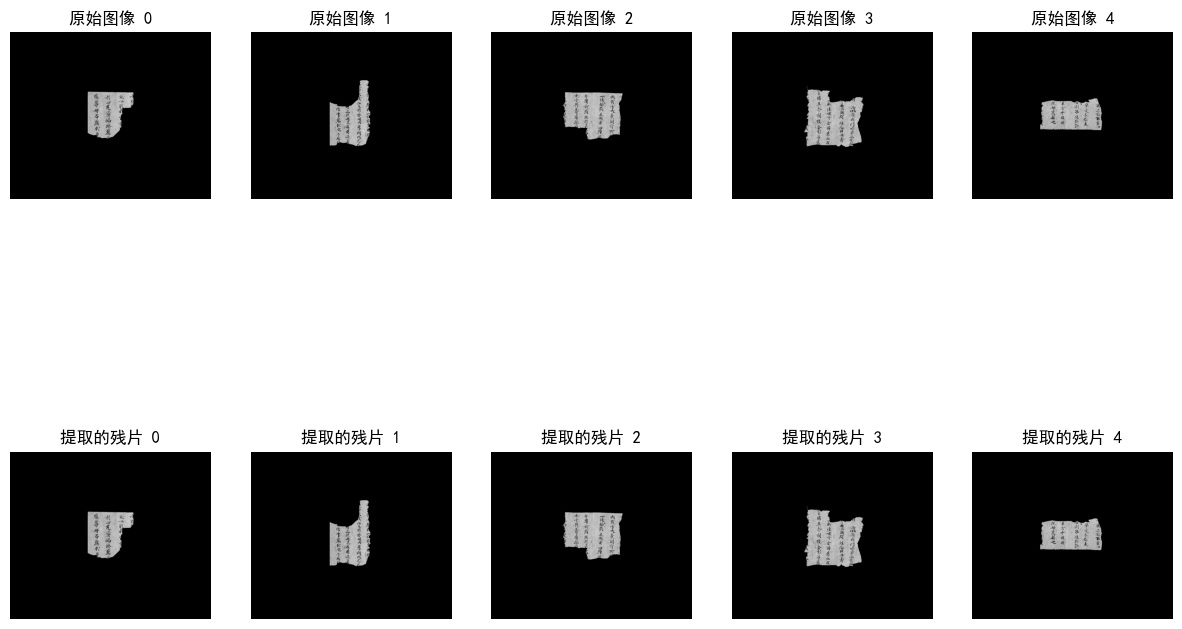

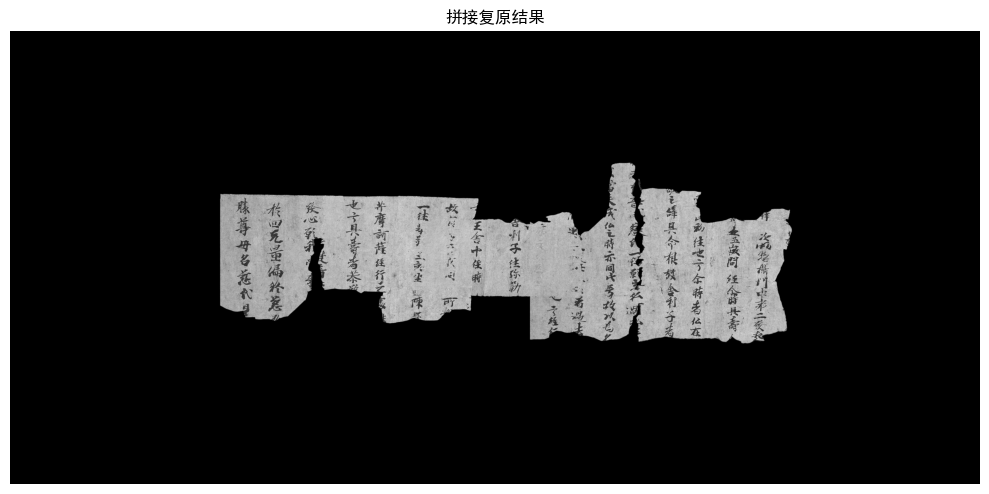

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Optional, Tuple, Union
import torch
from transformers import BertModel, BertTokenizer
from hmmlearn import hmm
from scipy.spatial.distance import cdist

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

class GraphNode:
    def __init__(
        self,
        node_id: int,
        freeman_codes: Dict[str, List[int]],
        centroid: Tuple[float, float],
        contour_centroids: List[Tuple[float, float]],
        semantic_vector: Optional[np.ndarray] = None,
        contours: Optional[List[np.ndarray]] = None,
        image_id: Optional[int] = None,
        original_image: Optional[np.ndarray] = None
    ):
        self.id = node_id
        self.freeman_codes = freeman_codes
        self.centroid = centroid
        self.contour_centroids = contour_centroids
        self.semantic_vector = semantic_vector
        self.contours = contours
        self.image_id = image_id
        self.original_image = original_image
        
    def __repr__(self):
        return f"GraphNode(id={self.id}, image_id={self.image_id}, centroid={self.centroid})"

class GraphEdge:
    def __init__(self, node1: int, node2: int, weight: Optional[float] = None):
        self.node1 = node1
        self.node2 = node2
        self.weight = weight
        
    def __repr__(self):
        return f"GraphEdge({self.node1} <-> {self.node2}, weight={self.weight})"

class Graph:
    def __init__(self):
        self.nodes: Dict[int, GraphNode] = {}
        self.edges: List[GraphEdge] = []
        self._next_node_id = 0
        
    def add_node(self, freeman_codes, centroid, contour_centroids, text=None, bert_model=None, bert_tokenizer=None, contours=None, image_id=None, original_image=None):
        semantic_vector = None
        if text and bert_model and bert_tokenizer:
            semantic_vector = self._generate_bert_vector(text, bert_model, bert_tokenizer)
        
        node_id = self._next_node_id
        self.nodes[node_id] = GraphNode(
            node_id=node_id,
            freeman_codes=freeman_codes,
            centroid=centroid,
            contour_centroids=contour_centroids,
            semantic_vector=semantic_vector,
            contours=contours,
            image_id=image_id,
            original_image=original_image
        )
        self._next_node_id += 1
        return node_id
    
    def add_edge(self, node1: int, node2: int, weight: Optional[float] = None):
        if node1 not in self.nodes or node2 not in self.nodes:
            raise ValueError("One or both nodes do not exist in the graph")
        self.edges.append(GraphEdge(node1, node2, weight))
    
    def _generate_bert_vector(self, text, bert_model, bert_tokenizer):
        inputs = bert_tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        return outputs.last_hidden_state[:, 0, :].numpy()
    
    def visualize(self, stitched_image: Optional[np.ndarray] = None):
        plt.figure(figsize=(15, 10))
        
        unique_image_ids = set(node.image_id for node in self.nodes.values())
        for idx, img_id in enumerate(unique_image_ids, 1):
            node = next(n for n in self.nodes.values() if n.image_id == img_id)
            original_img = node.original_image
            
            mask = np.zeros_like(original_img)
            cv2.drawContours(mask, [np.vstack(node.contours)], -1, (255), thickness=cv2.FILLED)
            fragment = cv2.bitwise_and(original_img, original_img, mask=mask)
            
            plt.subplot(2, len(unique_image_ids), idx)
            plt.imshow(original_img, cmap='gray')
            plt.title(f'原始图像 {img_id}')
            plt.axis('off')
            
            plt.subplot(2, len(unique_image_ids), idx + len(unique_image_ids))
            plt.imshow(fragment, cmap='gray')
            plt.title(f'提取的残片 {img_id}')
            plt.axis('off')
        
        if stitched_image is not None:
            plt.figure(figsize=(10, 6))
            plt.imshow(stitched_image, cmap='gray')
            plt.title('拼接复原结果')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

class ContourProcessor:
    def process_image(self, image_path: str) -> Tuple[List[np.ndarray], List[List[int]]]:
        """处理图像并提取轮廓"""
        try:
            original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if original is None:
                raise ValueError(f"无法读取图像: {image_path}")

            processed = self.preprocess(original)
            if processed is None:
                raise ValueError("图像预处理失败")
            
            contours, hierarchy = cv2.findContours(processed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            if not contours:
                raise ValueError("未找到任何轮廓")
            
            valid_contours = [cnt for cnt in contours if self.is_valid_contour(cnt, original.shape)]
            if not valid_contours:
                raise ValueError("未找到有效轮廓，请调整预处理参数")

            best_contour = max(valid_contours, key=lambda c: cv2.contourArea(c))
            perimeter = cv2.arcLength(best_contour, True)
            epsilon = 0.01 * perimeter
            approx = cv2.approxPolyDP(best_contour, epsilon, True)

            for _ in range(20):
                if len(approx) == 4:
                    break
                elif len(approx) > 4:
                    epsilon *= 1.1
                else:
                    epsilon *= 0.9
                approx = cv2.approxPolyDP(best_contour, epsilon, True)
            
            if len(approx) != 4:
                raise ValueError("无法近似为恰好4个点")

            contour_points = best_contour.reshape(-1, 2)
            indices = [np.argmin(np.sum((contour_points - p)**2, axis=1)) 
                      for p in approx.reshape(-1, 2)]
            indices.sort()

            if len(set(indices)) != 4:
                raise ValueError("近似点映射到重复索引")

            segments = [
                best_contour[indices[0]:indices[1]+1],
                best_contour[indices[1]:indices[2]+1],
                best_contour[indices[2]:indices[3]+1],
                np.vstack((best_contour[indices[3]:], best_contour[:indices[0]+1]))
            ]

            chain_codes = [self.freeman_chain_code(seg, closed=False) for seg in segments]
            
            if len(segments) != 4 or len(chain_codes) != 4:
                raise ValueError("轮廓分割或链码生成失败")
            
            return segments, chain_codes

        except Exception as e:
            print(f"图像处理错误: {str(e)}")
            raise

    def preprocess(self, img):
        if img is None:
            return None
            
        blurred = cv2.GaussianBlur(img, (7, 7), 1.5)
        thresh = cv2.adaptiveThreshold(
            blurred, 
            255, 
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY_INV, 
            21, 
            6
        )
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=3)
        return closed

    def is_valid_contour(self, cnt, img_shape):
        area = cv2.contourArea(cnt)
        if area < 500:
            return False
        
        x, y, w, h = cv2.boundingRect(cnt)
        if (x == 0 or y == 0 or 
            x + w >= img_shape[1] - 1 or 
            y + h >= img_shape[0] - 1):
            return False
        
        solidity = area / (w * h)
        return 0.3 < solidity < 0.9

    def freeman_chain_code(self, contour, closed=True):
        directions = [0, 1, 2, 3, 4, 5, 6, 7]
        dx = [1, 1, 0, -1, -1, -1, 0, 1]
        dy = [0, 1, 1, 1, 0, -1, -1, -1]
        chain_code = []
        n = len(contour)
        
        for i in range(n - 1 if not closed else n):
            current = contour[i % n][0]
            next_p = contour[(i + 1) % n][0]
            delta = (next_p[0] - current[0], next_p[1] - current[1])
            
            for j, (ddx, ddy) in enumerate(zip(dx, dy)):
                if delta == (ddx, ddy):
                    chain_code.append(j)
                    break
            else:
                raise ValueError(f"Invalid direction delta: {delta} at index {i}")
        
        return chain_code

    def compute_shape_context(self, contour, n_points=100, n_bins_r=5, n_bins_theta=12):
        contour = contour.squeeze()
        sampled_points = np.array([
            contour[int(i * len(contour) / n_points)] 
            for i in range(n_points)
        ])
        
        shape_contexts = []
        for i in range(n_points):
            diff = sampled_points - sampled_points[i]
            distances = np.sqrt(np.sum(diff**2, axis=1))
            angles = np.arctan2(diff[:, 1], diff[:, 0])
            
            angles[angles < 0] += 2 * np.pi
            
            max_dist = distances.max()
            min_dist = distances[distances > 0].min()
            log_r_bins = np.logspace(np.log10(min_dist), np.log10(max_dist), n_bins_r)
            theta_bins = np.linspace(0, 2*np.pi, n_bins_theta+1)
            
            hist, _, _ = np.histogram2d(
                distances, angles, 
                bins=[log_r_bins, theta_bins]
            )
            shape_contexts.append(hist.flatten())
            
        return np.array(shape_contexts)

    def dtw_distance(self, seq1, seq2):
        n, m = len(seq1), len(seq2)
        dtw_matrix = np.inf * np.ones((n + 1, m + 1))
        dtw_matrix[0, 0] = 0
        
        for i in range(1, n + 1):
            for j in range(1, m + 1):
                cost = np.linalg.norm(seq1[i-1] - seq2[j-1])
                dtw_matrix[i, j] = cost + min(
                    dtw_matrix[i-1, j],
                    dtw_matrix[i, j-1],
                    dtw_matrix[i-1, j-1]
                )
        
        return dtw_matrix[n, m]

    def evaluate_contour_match(self, contour1, contour2):
        try:
            contour1 = contour1.squeeze()
            contour2 = contour2.squeeze()
            
            if contour1.ndim != 2 or contour2.ndim != 2:
                return 0.0
            
            if len(contour1) < 5 or len(contour2) < 5:
                return 0.0
            
            sc1 = self.compute_shape_context(contour1)
            sc2 = self.compute_shape_context(contour2)
            
            dtw_dist = self.dtw_distance(sc1, sc2)
            
            max_possible_dist = np.sqrt(sc1.shape[1])
            match_score = 1.0 - (dtw_dist / (max_possible_dist + 1e-5))
            
            return np.clip(match_score, 0.0, 1.0)
            
        except Exception as e:
            print(f"轮廓匹配计算错误: {str(e)}")
            return 0.0

class GraphBuilder:
    def __init__(self):
        self.graph = Graph()
        self._contour_processor = ContourProcessor()
    
    def build_from_images(self, image_paths, texts=None, bert_model=None, bert_tokenizer=None):
        """构建图结构并拼接图像"""
        if texts and len(texts) != len(image_paths):
            raise ValueError("文本数量必须与图像数量匹配")
        
        node_ids = []
        original_imgs = {}
        
        # 处理每个输入图像
        for img_idx, image_path in enumerate(image_paths):
            try:
                print(f"处理图像 {image_path}")
                
                original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if original_img is None:
                    raise ValueError(f"无法读取图像: {image_path}")
                original_imgs[img_idx] = original_img
                
                text = texts[img_idx] if texts else None
                segments, chain_codes = self._contour_processor.process_image(image_path)
                
                contour_centroids = [self._compute_centroid(seg) for seg in segments]
                all_contour_points = np.vstack(segments)
                centroid = self._compute_centroid(all_contour_points)
                
                freeman_codes = {
                    'E1': chain_codes[0],
                    'E2': chain_codes[1],
                    'E3': chain_codes[2],
                    'E4': chain_codes[3]
                }
                
                node_id = self.graph.add_node(
                    freeman_codes=freeman_codes,
                    centroid=centroid,
                    contour_centroids=contour_centroids,
                    text=text,
                    bert_model=bert_model,
                    bert_tokenizer=bert_tokenizer,
                    contours=segments,
                    image_id=img_idx,
                    original_image=original_img
                )
                node_ids.append(node_id)
                
            except Exception as e:
                print(f"处理图像 {image_path} 时出错: {str(e)}")
                raise

        # 计算增强特征并获取最优序列
        enhanced_features = self._compute_enhanced_features(node_ids)
        optimal_sequence = self._train_hmm_and_get_sequence(enhanced_features, len(image_paths))
        stitched_image = self._stitch_images_based_on_sequence(node_ids, optimal_sequence)
        
        return self.graph, stitched_image

    def _compute_centroid(self, contour):
        """计算轮廓的质心"""
        M = cv2.moments(contour)
        cx = int(M['m10'] / (M['m00'] + 1e-5))
        cy = int(M['m01'] / (M['m00'] + 1e-5))
        return (cx, cy)

    def _compute_enhanced_features(self, node_ids):
        """计算增强的特征向量"""
        n_nodes = len(node_ids)
        # 8维特征：4个形状匹配度 + 4个几何特征
        features = np.zeros((n_nodes, 8))
        
        for i, node1_id in enumerate(node_ids):
            node1 = self.graph.nodes[node1_id]
            shape_scores = np.zeros(4)
            geometric_scores = np.zeros(4)
            
            for j, node2_id in enumerate(node_ids):
                if i == j:
                    continue
                
                node2 = self.graph.nodes[node2_id]
                
                for edge_idx in range(4):
                    contour1 = node1.contours[edge_idx]
                    contour2 = node2.contours[(edge_idx + 2) % 4]
                    
                    # 计算形状匹配度
                    shape_score = self._contour_processor.evaluate_contour_match(contour1, contour2)
                    # 计算几何特征
                    geo_score = self._compute_geometric_compatibility(contour1, contour2)
                    
                    shape_scores[edge_idx] = max(shape_scores[edge_idx], shape_score)
                    geometric_scores[edge_idx] = max(geometric_scores[edge_idx], geo_score)
            
            # 组合特征
            features[i] = np.concatenate([shape_scores, geometric_scores])
        
        return features

    def _compute_geometric_compatibility(self, contour1, contour2):
        """计算两个轮廓的几何兼容性"""
        try:
            # 计算轮廓长度
            len1 = cv2.arcLength(contour1, False)
            len2 = cv2.arcLength(contour2, False)
            
            # 长度比例相似度
            length_ratio = min(len1, len2) / max(len1, len2)
            
            # 计算方向差异
            _, (_, _), angle1 = cv2.fitEllipse(contour1)
            _, (_, _), angle2 = cv2.fitEllipse(contour2)
            angle_diff = min(abs(angle1 - angle2), 180 - abs(angle1 - angle2)) / 180.0
            
            # 综合得分
            geometric_score = 0.7 * length_ratio + 0.3 * (1 - angle_diff)
            return geometric_score
            
        except Exception as e:
            print(f"几何特征计算错误: {str(e)}")
            return 0.0

    def _train_hmm_and_get_sequence(self, observations, n_states):
        """训练HMM模型并获取序列"""
        try:
            n_components = min(n_states, len(observations) - 1)
            
            model = hmm.GaussianHMM(
                n_components=n_components,
                covariance_type="diag",
                n_iter=100,
                init_params=""  # 禁用自动初始化
            )
            
            n_features = observations.shape[1]
            
            # 初始化起始概率（基于边界特征）
            model.startprob_ = self._initialize_start_probabilities(observations, n_components)
            
            # 初始化改进的转移矩阵
            model.transmat_ = self._initialize_transition_matrix(observations, n_components)
            
            # 初始化均值和协方差
            model.means_ = np.zeros((n_components, n_features))
            model.covars_ = np.ones((n_components, n_features))
            
            model.fit(observations)
            _, state_sequence = model.decode(observations, algorithm="viterbi")
            
            return state_sequence
            
        except Exception as e:
            print(f"HMM训练错误: {str(e)}")
            return np.arange(len(observations))

    def _initialize_start_probabilities(self, observations, n_components):
        """初始化起始概率，考虑边界特征"""
        start_probs = np.zeros(n_components)
        
        for i in range(n_components):
            # 提取边界特征（前4个维度是形状匹配度）
            edge_features = observations[i, :4]
            
            # 计算边界完整性分数（值越小越可能是边界片段）
            boundary_score = np.mean(edge_features)
            
            # 将分数转换为概率
            start_probs[i] = 1.0 - boundary_score
        
        # 归一化
        start_probs = np.maximum(start_probs, 1e-5)  # 避免零概率
        start_probs /= start_probs.sum()
        
        return start_probs

    def _initialize_transition_matrix(self, observations, n_components):
        """初始化改进的转移矩阵"""
        transmat = np.zeros((n_components, n_components))
        
        for i in range(n_components):
            for j in range(n_components):
                if i != j:
                    transmat[i,j] = self._compute_transition_probability(
                        observations[i],
                        observations[j]
                    )
        
        # 添加自循环惩罚
        np.fill_diagonal(transmat, 0.01)
        
        # 归一化每行
        row_sums = transmat.sum(axis=1)
        transmat = transmat / row_sums[:, np.newaxis]
        
        return transmat

    def _compute_transition_probability(self, obs1, obs2):
        """计算两个状态间的转移概率"""
        # 提取特征
        shape_scores1 = obs1[:4]  # 形状匹配度
        geo_scores1 = obs1[4:8]   # 几何特征
        shape_scores2 = obs2[:4]
        geo_scores2 = obs2[4:8]
        
        # 计算边界匹配度
        edge_compatibility = self._compute_edge_compatibility(
            shape_scores1, shape_scores2,
            geo_scores1, geo_scores2
        )
        
        # 计算空间约束
        spatial_constraint = self._compute_spatial_constraint(
            geo_scores1, geo_scores2
        )
        
        # 计算方向一致性
        direction_consistency = self._compute_direction_consistency(
            geo_scores1, geo_scores2
        )
        
        # 综合评分
        transition_score = (
            0.4 * edge_compatibility +
            0.3 * spatial_constraint +
            0.3 * direction_consistency
        )
        
        return transition_score

    def _compute_edge_compatibility(self, shape_scores1, shape_scores2, geo_scores1, geo_scores2):
        """计算边界匹配度"""
        edge_scores = []
        for i in range(4):
            opposite_edge = (i + 2) % 4
            match_score = (
                0.7 * (shape_scores1[i] * shape_scores2[opposite_edge]) +
                0.3 * (geo_scores1[i] * geo_scores2[opposite_edge])
            )
            edge_scores.append(match_score)
        
        return max(edge_scores)

    def _compute_spatial_constraint(self, geo_scores1, geo_scores2):
        """计算空间约束"""
        length_compatibility = np.minimum(geo_scores1, geo_scores2).mean()
        distance_penalty = 1.0
        return length_compatibility * distance_penalty

    def _compute_direction_consistency(self, geo_scores1, geo_scores2):
        """计算方向一致性"""
        direction_diff = np.abs(geo_scores1 - geo_scores2)
        consistency = 1.0 - np.mean(direction_diff)
        return max(0.0, consistency)

    def _stitch_images_based_on_sequence(self, node_ids, sequence):
        """基于序列拼接图像"""
        sorted_indices = np.argsort(sequence)
        sorted_nodes = [self.graph.nodes[node_ids[i]] for i in sorted_indices]
        
        offsets = [(0, 0)]
        
        for i in range(1, len(sorted_nodes)):
            prev_node = sorted_nodes[i-1]
            curr_node = sorted_nodes[i]
            
            best_edge = 0
            best_score = 0
            for edge_idx in range(4):
                contour1 = prev_node.contours[edge_idx]
                contour2 = curr_node.contours[(edge_idx + 2) % 4]
                score = self._contour_processor.evaluate_contour_match(contour1, contour2)
                if score > best_score:
                    best_score = score
                    best_edge = edge_idx
            
            prev_offset = offsets[-1]
            contour_length = self._get_contour_length(prev_node.contours[best_edge])
            
            if best_edge == 0:   # 右
                new_offset = (prev_offset[0], prev_offset[1] + contour_length)
            elif best_edge == 1: # 下
                new_offset = (prev_offset[0] + contour_length, prev_offset[1])
            elif best_edge == 2: # 左
                new_offset = (prev_offset[0], prev_offset[1] - contour_length)
            else:                # 上
                new_offset = (prev_offset[0] - contour_length, prev_offset[1])
            
            offsets.append(new_offset)
        
        min_x = min(offset[0] for offset in offsets)
        min_y = min(offset[1] for offset in offsets)
        max_x = max(offset[0] + node.original_image.shape[0] for offset, node in zip(offsets, sorted_nodes))
        max_y = max(offset[1] + node.original_image.shape[1] for offset, node in zip(offsets, sorted_nodes))
        
        canvas_width = int(max_y - min_y)
        canvas_height = int(max_x - min_x)
        
        stitched = np.zeros((canvas_height, canvas_width), dtype=np.uint8)
        
        for node, offset in zip(sorted_nodes, offsets):
            x_pos = int(offset[0] - min_x)
            y_pos = int(offset[1] - min_y)
            
            mask = np.zeros_like(node.original_image)
            cv2.drawContours(mask, [np.vstack(node.contours)], -1, (255), thickness=cv2.FILLED)
            fragment = cv2.bitwise_and(node.original_image, node.original_image, mask=mask)
            
            h, w = fragment.shape
            x_end = min(x_pos + h, canvas_height)
            y_end = min(y_pos + w, canvas_width)
            
            if x_pos >= 0 and y_pos >= 0 and x_end <= canvas_height and y_end <= canvas_width:
                stitched[x_pos:x_end, y_pos:y_end] = np.maximum(
                    stitched[x_pos:x_end, y_pos:y_end],
                    fragment[:x_end-x_pos, :y_end-y_pos]
                )
        
        return stitched

    def _get_contour_length(self, contour):
        """计算轮廓长度"""
        return int(cv2.arcLength(contour, False))

if __name__ == "__main__":
    bert_model = None
    bert_tokenizer = None
    
    builder = GraphBuilder()
    
    image_paths = [
        r"C:\Users\28489\Desktop\paired\31\1.jpg",
        r"C:\Users\28489\Desktop\paired\31\2.jpg",
        r"C:\Users\28489\Desktop\paired\31\4.jpg",
        r"C:\Users\28489\Desktop\paired\31\5.jpg",
        r"C:\Users\28489\Desktop\paired\31\6.jpg"
    ]
    texts = ["图像1描述", "图像2描述", "图像4描述", "图像5描述", "图像6描述"]
    
    try:
        graph, stitched_image = builder.build_from_images(
            image_paths=image_paths,
            texts=texts,
            bert_model=bert_model,
            bert_tokenizer=bert_tokenizer
        )
        
        print(f"构建的图包含 {len(graph.nodes)} 个节点和 {len(graph.edges)} 条边")
        graph.visualize(stitched_image)
        
    except Exception as e:
        print(f"处理图像时出错: {str(e)}")